In [1]:
'''
Deutsch - Jozsa Benchmark Program - Qsim
'''
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, BasicAer
from qiskit import *


import numpy as np
import matplotlib.pyplot as plt 
import sys, time

#import metrics
#import execute as ex 

# Noise parameters
options = { } #if Noise is None

options_noisy = { #if Noise is not None
    'plot': False,
    "thermal_factor": 0.0,
    'show_partition': False,
    "decoherence_factor": 0.9,
    "depolarization_factor": 0.9,
    "bell_depolarization_factor": 0.9,
    "decay_factor": 0.9,
    "rotation_error": {'rx':[1.0, 0.0], 'ry':[1.0, 0.0], 'rz':[1.0, 0.0]},
    "tsp_model_error": [1.0, 0.0],
}

# Selection of basis gate set for transpilation
# Note: selector 1 is a hardware agnostic gate set
basis_selector = 2
basis_gates_array = [
    [],
    ['rx', 'ry', 'rz', 'cx'],       # a common basis set, default
    ['cx', 'rz', 'sx', 'x'],        # IBM default basis set
    ['rx', 'ry', 'rxx'],            # IonQ default basis set
    ['h', 'p', 'cx'],               # another common basis set
    ['u', 'cx']                     # general unitaries basis gates
]

#Benchmark Name
benchmark_name = "Duestch - Jozsa Qsim"

np.random.seed(0)

# This sets the seed of the random number generator to the specified value, in this case, 0. 
# Setting the seed to a specific value ensures that the sequence of random numbers 
# generated is the same every time the program is run.

verbose = False

# When verbose is set to False, it usually means that the program will run without providing
# detailed or extra information, resulting in a more concise and less informative output.

# saved circuits for display
QC_ = None
C_ORACLE_ = None
B_ORACLE_ = None

In [2]:
############# Circuit Definition ################

# Define constant_oracle function
def constant_oracle(input_size, num_qubits):
    qc = QuantumCircuit(num_qubits, name=f"Uf")

    output = np.random.randint(2)
    if output == 1:
        qc.x(input_size)

    global C_ORACLE_
    if C_ORACLE_ is None or num_qubits <= 6:
        if num_qubits < 9:
            C_ORACLE_ = qc

    return qc

In [3]:
# Define balanced_oracle function
def balanced_oracle(input_size, num_qubits):
    qc = QuantumCircuit(num_qubits, name=f"Uf")

    b_str = "10101010101010101010"  # permit input_string up to 20 chars
    for qubit in range(input_size):
        if b_str[qubit] == '1':
            qc.x(qubit)

    qc.barrier()

    for qubit in range(input_size):
        qc.cx(qubit, input_size)

    qc.barrier()

    for qubit in range(input_size):
        if b_str[qubit] == '1':
            qc.x(qubit)

    global B_ORACLE_
    if B_ORACLE_ is None or num_qubits <= 6:
        if num_qubits < 9:
            B_ORACLE_ = qc

    return qc

In [4]:
# Define DeutschJozsa function
def DeutschJozsa(num_qubits, type):
    input_size = num_qubits - 1

    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(input_size)
    qc = QuantumCircuit(qr, cr, name=f"dj-{num_qubits}-{type}")

    for qubit in range(input_size):
        qc.h(qubit)
    qc.x(input_size)
    qc.h(input_size)

    qc.barrier()

    if type == 0:
        Uf = constant_oracle(input_size, num_qubits)
    else:
        Uf = balanced_oracle(input_size, num_qubits)

    qc.append(Uf, qr)

    qc.barrier()

    for qubit in range(num_qubits):
        qc.h(qubit)

    qc.x(input_size)

    qc.barrier()

    for i in range(input_size):
        qc.measure(i, i, basis='Ensemble', add_param='Z')

    global QC_
    if QC_ is None or num_qubits <= 2:
        if num_qubits < 9:
            QC_ = qc

    return qc

In [5]:
# if main, execute method
#if __name__ == '__main__': run()

In [6]:
############################################
# DATA ANALYSIS - FIDELITY CALCULATIONS

## Uniform distribution function commonly used
def rescale_fidelity(fidelity, floor_fidelity, new_floor_fidelity):
    """
    Linearly rescales our fidelities to allow comparisons of fidelities across benchmarks
    
    fidelity: raw fidelity to rescale
    floor_fidelity: threshold fidelity which is equivalent to random guessing
    new_floor_fidelity: what we rescale the floor_fidelity to 

    Ex, with floor_fidelity = 0.25, new_floor_fidelity = 0.0:
        1 -> 1;
        0.25 -> 0;
        0.5 -> 0.3333;
    """
    rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
    
    # ensure fidelity is within bounds (0, 1)
    if rescaled_fidelity < 0:
        rescaled_fidelity = 0.0
    if rescaled_fidelity > 1:
        rescaled_fidelity = 1.0
    
    return rescaled_fidelity
    
def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist                

### Analysis methods to be expanded and eventually compiled into a separate analysis.py file
import math, functools

def hellinger_fidelity_with_expected(p, q):
    """ p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    if q_sum == 0:
        print("ERROR: polarization_fidelity(), expected distribution is invalid, all counts equal to 0")
        return 0

    p_normed = {}
    for key, val in p.items():
        if p_sum != 0:
            p_normed[key] = val/p_sum
        else:
            p_normed[key] = 0

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    
    # in some situations (error mitigation) this can go negative, use abs value
    if total < 0:
        print(f"WARNING: using absolute value in fidelity calculation")
        total = abs(total)
        
    dist = np.sqrt(total)/np.sqrt(2)
    fidelity = (1-dist**2)**2

    return fidelity

def polarization_fidelity(counts, correct_dist, thermal_dist=None):
    """
    Combines Hellinger fidelity and polarization rescaling into fidelity calculation
    used in every benchmark

    counts: the measurement outcomes after `num_shots` algorithm runs
    correct_dist: the distribution we expect to get for the algorithm running perfectly
    thermal_dist: optional distribution to pass in distribution from a uniform
                  superposition over all states. If `None`: generated as 
                  `uniform_dist` with the same qubits as in `counts`
                  
    returns both polarization fidelity and the hellinger fidelity

    Polarization from: `https://arxiv.org/abs/2008.11294v1`
    """
    num_measured_qubits = len(list(correct_dist.keys())[0])
    print(num_measured_qubits)
    
    counts = {k.zfill(num_measured_qubits): v for k, v in counts.items()}
    
    # calculate hellinger fidelity between measured expectation values and correct distribution
    hf_fidelity = hellinger_fidelity_with_expected(counts,correct_dist)
    
    # to limit cpu and memory utilization, skip noise correction if more than 16 measured qubits
    if num_measured_qubits > 16:
        return { 'fidelity':hf_fidelity, 'hf_fidelity':hf_fidelity }

    # if not provided, generate thermal dist based on number of qubits
    if thermal_dist == None:
        thermal_dist = uniform_dist(num_measured_qubits)

    # set our fidelity rescaling value as the hellinger fidelity for a depolarized state
    floor_fidelity = hellinger_fidelity_with_expected(thermal_dist, correct_dist)

    # rescale fidelity result so uniform superposition (random guessing) returns fidelity
    # rescaled to 0 to provide a better measure of success of the algorithm (polarization)
    new_floor_fidelity = 0
    fidelity = rescale_fidelity(hf_fidelity, floor_fidelity, new_floor_fidelity)

    return { 'fidelity':fidelity, 'hf_fidelity':hf_fidelity }



In [7]:
def det_type(input_size, circuit_type):
    if circuit_type == 0:
        key = '0' * (input_size-1)
    else:
        #key = '1' * input_size
        key = '1'*(input_size-1)
    correct_dist = {key: 1.0}
    return correct_dist

qc of 3 qubits of type 0
      ┌───┐      ░ ┌─────┐ ░ ┌───┐      ░  ░ ┌─┐ ░  ░     ░ 
q0_0: ┤ H ├──────░─┤0    ├─░─┤ H ├──────░──░─┤M├─░──░─────░─
      ├───┤      ░ │     │ ░ ├───┤      ░  ░ └╥┘ ░  ░ ┌─┐ ░ 
q0_1: ┤ H ├──────░─┤1 Uf ├─░─┤ H ├──────░──░──╫──░──░─┤M├─░─
      ├───┤┌───┐ ░ │     │ ░ ├───┤┌───┐ ░  ░  ║  ░  ░ └╥┘ ░ 
q0_2: ┤ X ├┤ H ├─░─┤2    ├─░─┤ H ├┤ X ├─░──░──╫──░──░──╫──░─
      └───┘└───┘ ░ └─────┘ ░ └───┘└───┘ ░  ░  ║  ░  ░  ║  ░ 
c0: 2/════════════════════════════════════════╩════════╩════
                                              0        1    
{'000': 1.0, '001': 0.0, '010': 0.0, '011': 0.0, '100': 0.0, '101': 0.0, '110': 0.0, '111': 0.0}
{'00': 1000, '01': 0, '10': 0, '11': 0}
2
qc of 3 qubits of type 1
       ┌───┐      ░ ┌─────┐ ░ ┌───┐      ░  ░ ┌─┐ ░  ░     ░ 
q27_0: ┤ H ├──────░─┤0    ├─░─┤ H ├──────░──░─┤M├─░──░─────░─
       ├───┤      ░ │     │ ░ ├───┤      ░  ░ └╥┘ ░  ░ ┌─┐ ░ 
q27_1: ┤ H ├──────░─┤1 Uf ├─░─┤ H ├──────░──░──╫──░──░─┤M├─░─
       ├───┤┌─

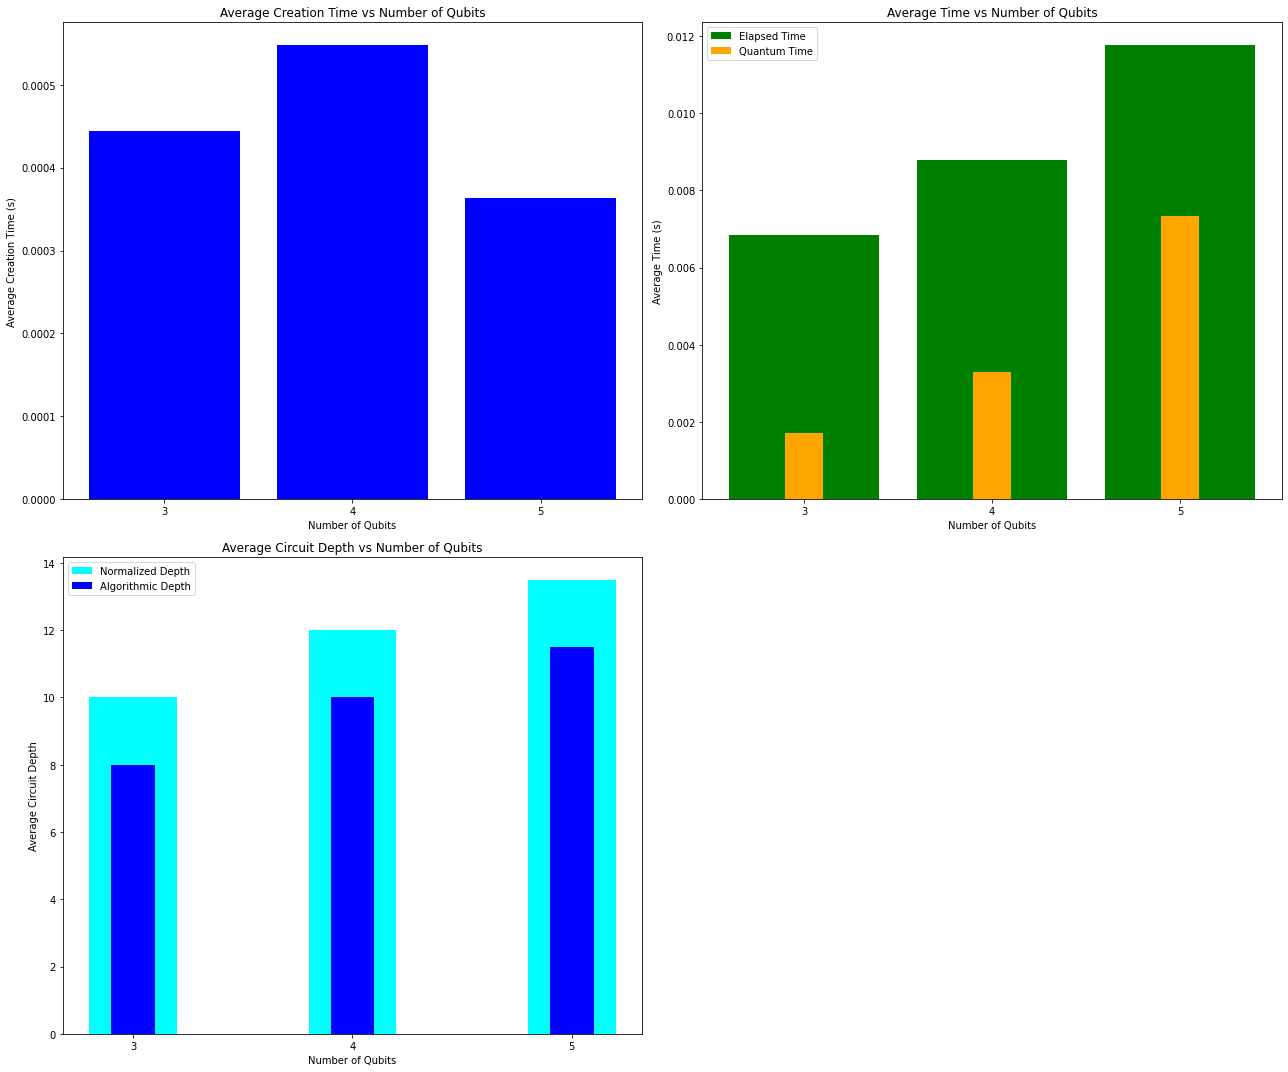

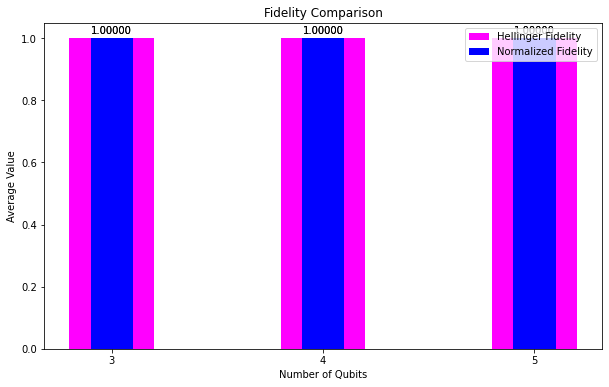

{3: [1.0, 1.0], 4: [1.0, 1.0], 5: [1.0, 1.0]}
{3: [1.0, 1.0], 4: [1.0, 1.0], 5: [1.0, 1.0]}
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]


In [8]:
# Function to calculate circuit depth
def calculate_circuit_depth(qc):
    # Calculate the depth of the circuit
    depth = qc.depth()
    return depth

def combine_probabilities(prob, num_qubits):
    proj_prob = {}
    input_size = num_qubits-1
    # Generate binary combinations for n qubits
    binary_combinations = [bin(i)[2:].zfill(input_size) for i in range(2**input_size)]

    # Combine probabilities and errors for each projection
    if input_size<2:
        for i in range(2**(input_size-1)):
            proj_prob[bin(i)[2:].zfill(input_size-1)] = prob.get(bin(i)[2:].zfill(input_size-1) + '0', 0) + prob.get(bin(i)[2:].zfill(input_size-1) + '1', 0)
    else:
        for i in range(2**(input_size-1)):
            proj_prob[bin(i)[2:].zfill(input_size-1) + '0'] = sum(prob[bin(i)[2:].zfill(input_size-1) + '0' + str(j)] for j in range(2))
            proj_prob[bin(i)[2:].zfill(input_size-1) + '1'] = sum(prob[bin(i)[2:].zfill(input_size-1) + '1' + str(j)] for j in range(2))

    return proj_prob

def calculate_transpiled_depth(qc,basis_selector):
    # use either the backend or one of the basis gate sets
    if basis_selector == 0:
        qc = transpile(qc, backend)
        
    else:
        basis_gates = basis_gates_array[basis_selector]
        qc = transpile(qc, basis_gates=basis_gates, seed_transpiler=0)
    transpiled_depth = qc.depth()
    return transpiled_depth

def plot_data(fidelity_data, Hf_fidelity_data, title):
    avg_fidelity_means = []
    avg_Hf_fidelity_means = []
    avg_num_qubits_values = list(fidelity_data.keys())

    # Calculate the average fidelity and Hamming fidelity for each unique number of qubits
    for num_qubits in avg_num_qubits_values:
        avg_fidelity = np.average(fidelity_data[num_qubits])
        avg_fidelity_means.append(avg_fidelity)

        avg_Hf_fidelity = np.mean(Hf_fidelity_data[num_qubits])
        avg_Hf_fidelity_means.append(avg_Hf_fidelity)
    
    

    # Plot the data
    x = np.arange(len(avg_num_qubits_values))
    
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects2 =ax.bar(x, avg_Hf_fidelity_means, width=0.4, label='Hellinger Fidelity',color="magenta")
    rects1 = ax.bar(x, avg_fidelity_means, width=0.2, label='Normalized Fidelity', color="blue")
    
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel('Average Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(avg_num_qubits_values)
    ax.legend()
    
    # Add labels to the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.5f}'.format(height),  # Formatting to two decimal places
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.show()
    print(fidelity_data)
    print(Hf_fidelity_data)
    print(avg_fidelity_means)
    print(avg_Hf_fidelity_means)
    
backend = BasicAer.get_backend('dm_simulator')



# Function to execute the benchmark program, accumulate metrics, and calculate circuit depths
def run_and_accumulate_metrics_with_depth(min_qubits=3, max_qubits=5, skip_qubits=1, max_circuits=3, num_shots=1000):
    creation_times = []
    elapsed_times = []
    quantum_times = []
    circuit_depths = []
    transpiled_depths = []
    fidelity_data = {}
    Hf_fidelity_data = {}
    
    # Execute Benchmark Program N times for multiple circuit sizes
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
        fidelity_data[num_qubits] = []
        Hf_fidelity_data[num_qubits] = []
        num_circuits = min(2, max_circuits)
        for type in range(num_circuits):
            ts = time.time()
            qc = DeutschJozsa(num_qubits, type)

            #creation time
            creation_time = time.time() - ts
            creation_times.append(creation_time)
            print(f"qc of {num_qubits} qubits of type {type}")
            print(qc)
            # collapse the sub-circuit levels used in this benchmark (for qiskit)
            qc=qc.decompose()
            
            # Calculate circuit depth
            depth = calculate_circuit_depth(qc)
            circuit_depths.append(depth)

            # Calculate transpiled circuit depth
            transpiled_depth = calculate_transpiled_depth(qc,basis_selector)
            transpiled_depths.append(transpiled_depth)

            #execution
            ts = time.time()
            job = execute(qc, backend, shots=num_shots, **options)
            result = job.result()
            elapsed_time = time.time() - ts
            elapsed_times.append(elapsed_time)
            
            # Calculate quantum processing time (excluding creation time)
            quantum_time = result.results[0].running_time_taken
            quantum_times.append(quantum_time)

            #ensemble probability
            prob = result.results[0].data.ensemble_probability
            print(prob)
            proj_prob = combine_probabilities(prob,num_qubits)
            counts = proj_prob
            
            for key in counts.keys():
               counts[key] = int(counts[key] * num_shots)
            print(counts)
            correct_dist = det_type(num_qubits, type)

            #fidelity
            fidelity_dict = polarization_fidelity(counts, correct_dist)
            fidelity_data[num_qubits].append(fidelity_dict['fidelity'])
            Hf_fidelity_data[num_qubits].append(fidelity_dict['hf_fidelity'])
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nConstant Oracle 'Uf' ="); print(C_ORACLE_ if C_ORACLE_ != None else " ... too large or not used!")
    print("\nBalanced Oracle 'Uf' ="); print(B_ORACLE_ if B_ORACLE_ != None else " ... too large or not used!")
    
    return creation_times, elapsed_times, quantum_times, circuit_depths, transpiled_depths, fidelity_data, Hf_fidelity_data

# Define the range of qubits for the x-axis
num_qubits_range = range(3, 5+1)


# Execute the benchmark program, accumulate metrics, and calculate circuit depths
creation_times, elapsed_times, quantum_times, circuit_depths,transpiled_depths, fidelity_data, Hf_fidelity_data = run_and_accumulate_metrics_with_depth()

#avg_fidelity_means, avg_Hf_fidelity_means = fidelity_data()

# Calculate average creation time, elapsed time, quantum processing time, and circuit depth for each number of qubits
avg_creation_times = [np.mean(creation_times[i:i+2]) for i in range(0, len(creation_times), 2)]
avg_elapsed_times = [np.mean(elapsed_times[i:i+2]) for i in range(0, len(elapsed_times), 2)]
avg_quantum_times = [np.mean(quantum_times[i:i+2]) for i in range(0, len(quantum_times), 2)]
avg_circuit_depths = [np.mean(circuit_depths[i:i+2]) for i in range(0, len(circuit_depths), 2)]
avg_transpiled_depths = [np.mean(transpiled_depths[i:i+2]) for i in range(0, len(transpiled_depths), 2)]


# Plot histograms for average creation time, average elapsed time, average quantum processing time, and average circuit depth versus the number of qubits
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
plt.bar(num_qubits_range, avg_creation_times, color='blue')
plt.xlabel('Number of Qubits')
plt.ylabel('Average Creation Time (s)')
plt.title('Average Creation Time vs Number of Qubits')

plt.subplot(2, 2, 2)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
plt.bar(num_qubits_range, avg_elapsed_times, color='green',label ='Elapsed Time')
plt.bar(num_qubits_range, avg_quantum_times, color='orange',label ='Quantum Time', width=0.2)
plt.xlabel('Number of Qubits')
plt.ylabel('Average Time (s)')
plt.title('Average Time vs Number of Qubits')
plt.legend()

plt.subplot(2, 2, 3)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
plt.bar(num_qubits_range, avg_transpiled_depths, color='cyan', label='Normalized Depth', width=0.4)  # Adjust width here
plt.bar(num_qubits_range, avg_circuit_depths, color='blue', label='Algorithmic Depth', width=0.2)  # Adjust width here
plt.xlabel('Number of Qubits')
plt.ylabel('Average Circuit Depth')
plt.title('Average Circuit Depth vs Number of Qubits')
plt.legend()


plt.tight_layout()
plt.show()

# Calculate the fidelity data
plot_data(fidelity_data, Hf_fidelity_data, "Fidelity Comparison")
